# Eclipse Path Maps
This Jupyter notebook gives an example of creating a map that overlays transmitter-receiver paths with
the 2023 and 2024 eclipse paths.

In [1]:
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt

import cartopy
import cartopy.crs as ccrs

# Geographiclib - https://geographiclib.sourceforge.io/Python/2.0/
# conda install conda-forge::geographiclib
from geographiclib.geodesic import Geodesic
geod = Geodesic.WGS84

from eclipse_calc.solarContext import EclipseData
from eclipse_calc.rayTracePaths import RayTracePaths

%matplotlib inline

In [2]:
plt.rcParams['font.size']      = 18
plt.rcParams['font.weight']    = 'bold'
plt.rcParams['axes.titleweight']    = 'bold'
plt.rcParams['axes.grid']      = True
plt.rcParams['axes.xmargin']   = 0
plt.rcParams['grid.linestyle'] = ':'

In [3]:
def overlay_eclipses(ax):
        # ## Load Eclipse Data
        eclipses = {}

        meta = {}
        meta['obsc_min']    = 0.85
        meta['alpha']       = 0.25
        meta['cmap']        = mpl.cm.Purples
        fname = 'data/obscurations/20231014.1400_20231014.2100_300kmAlt_0.2dlat_0.2dlon/20231014.1400_20231014.2100_300kmAlt_0.2dlat_0.2dlon_MAX_OBSCURATION.csv.bz2'

        tas = []
        ta  = {}
        ta['lat']       = 45.
        ta['lon']       = -128.
        ta['startEnd']  = 'start'
        ta['tp']        = {'va':'bottom'}
        tas.append(ta)

        ta  = {}
        ta['lat']       = 22.
        ta['lon']       = -90. 
        ta['startEnd']  = 'end'
        tas.append(ta)
        meta['track_annotate'] = tas

        ecl = EclipseData(fname,meta=meta)
        eclipses['2023']    = ecl

        meta = {}
        meta['obsc_min']    = 0.975
        fname                   = 'data/obscurations/20240408.1500_20240408.2100_300kmAlt_0.2dlat_0.2dlon/20240408.1500_20240408.2100_300kmAlt_0.2dlat_0.2dlon_MAX_OBSCURATION.csv.bz2'
        tas = []
        ta  = {}
        ta['lat']       = 20
        ta['lon']       = -107.
        ta['startEnd']  = 'start'
        tas.append(ta)

        ta  = {}
        ta['lat']       =  47.
        ta['lon']       = -61. 
        ta['startEnd']  = 'end'
        tas.append(ta)
        meta['track_annotate'] = tas
        ecl                     = EclipseData(fname,meta=meta)
        ecl = EclipseData(fname,meta=meta)
        eclipses['2024']    = ecl

        for ecl_year,ecl in eclipses.items():
            ecl.overlay_obscuration(ax)
            ecl.overlay_track(ax)

In [4]:
def plot_map(paths_df=None,plot_eclipse=False,title=None,figsize=(15,8)):
    ## World
    #xlim    = (-180,180)
    #ylim    = (-90,90)
    
    # Continental US (CONUS)
    xlim    = (-130,-56)
    ylim    = (20,55)
    
    ## CONUS + Canada
    #xlim    = (-130,-56)
    #ylim    = (20,80)
    
    fig     = plt.figure(figsize=figsize)
    ax      = fig.add_subplot(111,projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_title('')
    ax.gridlines(draw_labels=True)

    if paths_df is not None:
        fontdict = {'size':'large','weight':'bold'}
        offset   = 1.1
        cycle    = plt.rcParams['axes.prop_cycle']
        for inx,(rinx,row) in enumerate(paths_df.iterrows()):
            color = list(cycle)[inx%len(cycle)].get('color')
            # Plot Transmitter and Receiver locations
            pt_dcts = {}
            pt_dcts['tx'] = {'marker':'*','s':450}
            pt_dcts['rx'] = {'marker':'v','s':150}
            for pt_key,pt_dct in pt_dcts.items():
                lat        = row.get(pt_key+'_lat')
                lon        = row.get(pt_key+'_lon')
                lbl        = row.get(pt_key+'_lbl')

                if lat is None: continue
                    
                latLonStr  = '{:0.1f}\N{DEGREE SIGN}N, {:0.1f}\N{DEGREE SIGN}E'.format(lat,lon)
                if lbl is not None:
                    lbl_latLon = '{!s} ({!s})'.format(lbl,latLonStr)
                else:
                    lbl_latLon = '({!s})'.format(latLonStr)
                if lon > 180:
                    lon = lon - 360.
    
                ax.scatter(lon,lat,zorder=110,label=lbl_latLon,ec='k',fc=color,**pt_dct)
                if lbl is not None:
                    ax.text(lon,lat+offset,lbl,fontdict=fontdict,ha='center',zorder=10000)
            # Plot the path
            if 'end_lat' in row.keys():
                end_key = 'end'
            elif 'rx_lat' in row.keys():
                end_key = 'rx'
            else:
                end_key = None

            if end_key is not None:
                tx_lat       = row.get('tx_lat')
                tx_lon       = row.get('tx_lon')
                
                end_lat      = row.get(end_key+'_lat')
                end_lon      = row.get(end_key+'_lon')
                end_lbl      = row.get(end_key+'_lbl')
                if end_lon > 180:
                    end_lon = end_lon - 360.

                lbl          = '{!s}-{!s}'.format(row['tx_lbl'],end_lbl)
                if end_key == 'end' and 'tx_rx_range_km' in row.keys():
                    rx_rng       = row.get('tx_rx_range_km')
                    end_rng      = row.get('tx_'+end_key+'_range_km')
                    end_azm      = row.get('tx_'+end_key+'_azm')
                    lbl_rngAzm   = '{!s} ({:.0f} km, {:.0f} km, {:.0f}\N{DEGREE SIGN} azm)'.format(lbl,rx_rng,end_rng,end_azm)
                else:
                    end_rng      = row.get('tx_'+end_key+'_range_km')
                    end_azm      = row.get('tx_'+end_key+'_azm')
                    lbl_rngAzm   = '{!s} ({:.0f} km, {:.0f}\N{DEGREE SIGN} azm)'.format(lbl,end_rng,end_azm)


                # Determine the ranges and azimuth along the profile path.
                invl    = geod.InverseLine(tx_lat,tx_lon,end_lat,end_lon)
                dist    = invl.s13*1e-3   # Distance in km
                az      = invl.azi1
                range_step = 1.

                ranges  = np.arange(0,dist,range_step)
        
                glats   = []
                glons   = []
                for x in ranges:
                    s   = min(x*1e3,invl.s13) # invl.s13 is the total line distance in m
                    tmp = invl.Position(s,Geodesic.STANDARD)
                    glat        = tmp['lat2']
                    glon        = tmp['lon2']
        
                    glats.append(glat)
                    glons.append(glon)

                ax.plot(glons,glats,label=lbl_rngAzm,lw=3,color=color,transform=ccrs.PlateCarree())
                
        if plot_eclipse:
            overlay_eclipses(ax)
            
    # ax.legend(loc='lower right',fontsize='small')
    ax.legend(loc='lower right',prop={'size':'x-small','weight':'normal'},framealpha=1)
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    if title is not None:
        ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

# 2023 Annular and 2024 Total Solar Eclipses

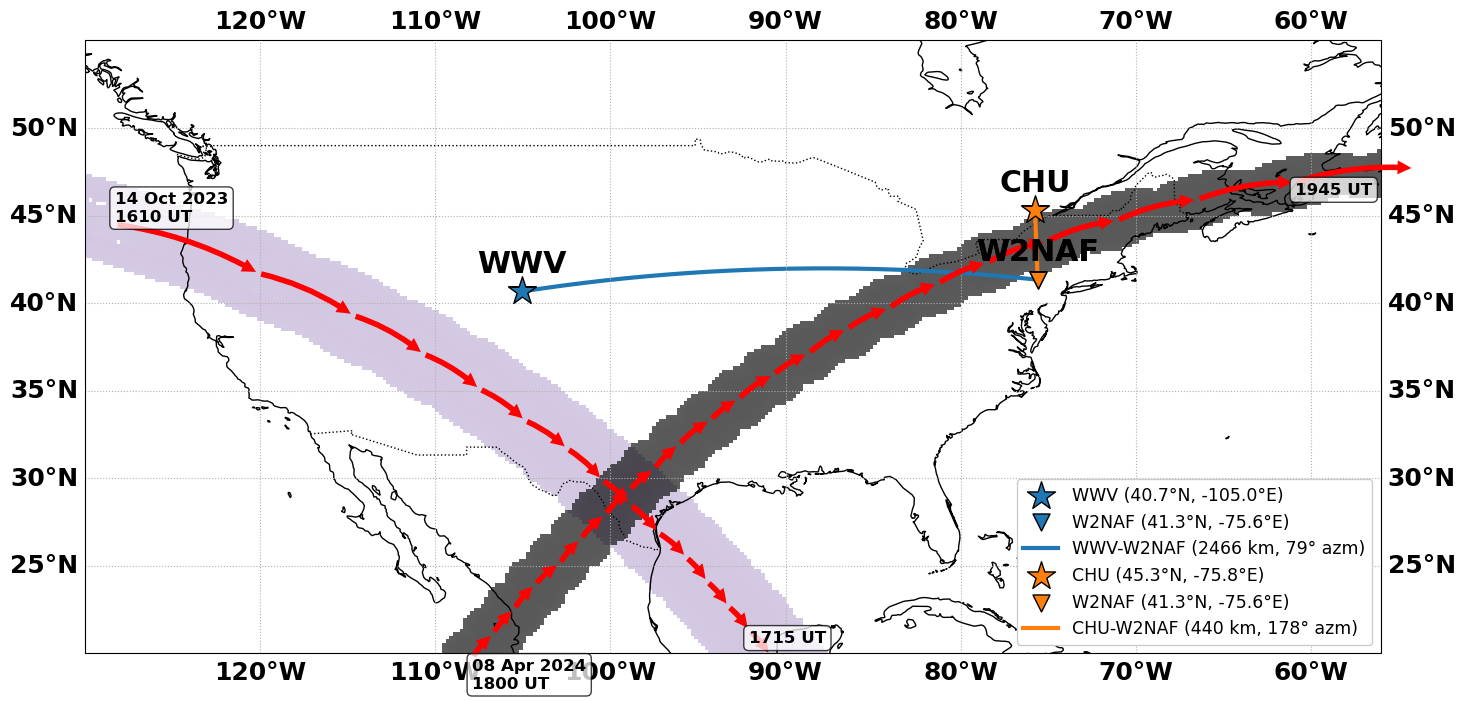

,tx_lbl,tx_lat,tx_lon,rx_lbl,rx_lat,rx_lon,tx_rx_range_km,tx_rx_azm
0,WWV,40.668300,-105.038400,W2NAF,41.335116,-75.600692,2465.861950,78.545767
1,CHU,45.294806,-75.757861,W2NAF,41.335116,-75.600692,440.101681,178.285607


In [5]:
pdcts = []

pdct = {}
pdct['tx_lbl']  = 'WWV'
pdct['tx_lat']  =   40.6683
pdct['tx_lon']  = -105.0384
pdct['rx_lbl']  = 'W2NAF'
pdct['rx_lat']  =  41.335116
pdct['rx_lon']  = -75.600692
# Uncomment the next line if you want to extend the path beyond the receiver. This can be useful for setting up ray trace paths.
# pdct['tx_end_range_km'] = 3000. 

pdcts.append(pdct)

pdct = {}
pdct['tx_lbl']  = 'CHU'
pdct['tx_lat']  =   45.294806
pdct['tx_lon']  =  -75.757861
pdct['rx_lbl']  = 'W2NAF'
pdct['rx_lat']  =  41.335116
pdct['rx_lon']  = -75.600692
# Uncomment the next line if you want to extend the path beyond the receiver. This can be useful for setting up ray trace paths.
# pdct['tx_end_range_km'] = 1000.

pdcts.append(pdct)

title = []
title.append('Annular Solar Eclipe - 14 October 2023')
title.append('Total Solar Eclipe - 8 April 2024')
title = '\n'.join(title)

eclipse_paths = RayTracePaths(pdcts)
plot_map(eclipse_paths.df,plot_eclipse=True)
eclipse_paths.df